<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import cv2
import hashlib

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.4.1
Eager mode: True
Found GPU at: /device:GPU:0


In [3]:
def show_image(image, title=None):
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(image.reshape(28, 28), cmap='Greys')
  if title is not None:
    plt.title(title)
  plt.show()

In [34]:
def show_prediction(image, truth, prediction, label_descriptions=None):
  prediction = np.argmax(prediction)
  prediction = prediction if label_descriptions is None else label_descriptions[prediction]
  truth = truth if label_descriptions is None else label_descriptions[truth]
  title = f"Prediction: {prediction} / Truth: {truth}"
  show_image(image, title)

In [5]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    height_zoom = size[1] / cam.shape[0]
    width_zoom = size[0] / cam.shape[1]
    heatmap = sp.ndimage.zoom(cam, (height_zoom, width_zoom), order=2)
 
  return heatmap

In [6]:
def show_heatmap(img, cam, size, resize=True, title=None):
  img = img.reshape(size[0], size[1])
  heatmap = get_heatmap(cam, size, resize)

  # plot
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(img, alpha=0.5, cmap='Greys')
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  
  if title is not None:
    plt.title(title)
  
  plt.show()  

In [7]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [8]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [9]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [10]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [11]:
def get_sample(test_set, idx=-1):
  idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][idx]
  test_label = np.argmax(test_set[1][idx])

  return test_image, test_label

In [12]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [13]:
def get_prediction(model, test_set, idx=-1):
  x, y = get_sample(test_set, idx)
  prediction = predict(model, x)

  return x, y, prediction, idx

In [14]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

In [86]:
def copy_model(original_model, trainable=False):
  new_model = keras.models.clone_model(original_model)
  new_model.set_weights(original_model.get_weights())
  new_model.trainable = trainable
  return new_model

#MNIST

In [15]:
mnist_num_classes = 10
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Epoch 1/15
422/422 [==============================] - 34s 7ms/step - loss: 0.9981 - accuracy: 0.6757 - val_loss: 0.1259 - val_accuracy: 0.9650
Epoch 2/15
422/422 [==============================] - 3s 6ms/step - loss: 0.1927 - accuracy: 0.9417 - val_loss: 0.0936 - val_accuracy: 0.9718
Epoch 3/15
422/422 [==============================] - 3s 6ms/step - loss: 0.1327 - accuracy: 0.9597 - val_loss: 0.0658 - val_accuracy: 0.9800
Epoch 4/15
422/422 [==============================] - 3s 6ms/step - loss: 0.1055 - accuracy: 0.9678 - val_loss: 0.0603 - val_accuracy: 0.9837
Epoch 5/15
422/422 [==============================] - 3s 6ms/step - loss: 0.0816 - accuracy: 0.9750 - val_loss: 0.0431 - val_accuracy: 0.9883
Epoch 6/15
422/422 [==============================] - 3s 6ms/step - loss: 0.0695 - accuracy: 0.9783 - val_loss: 0.0465 - val_accuracy: 0.9872
Epoch 7/15
422/422 [==============================] - 3s 6ms/step - loss: 0.0621 - accuracy: 0.9812 - val_loss: 0.0407 - val_accuracy: 0.9878
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


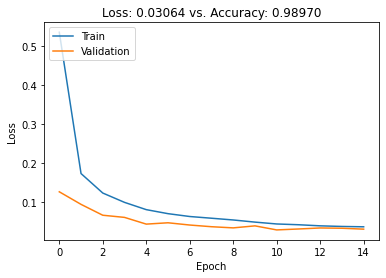

In [16]:
model_mnist = create_mnist_model("gap_shallow", (28, 28, 1), mnist_num_classes, mnist_train)

# model_mnist, history_mnist = load_model("gap_shallow")
start_time = time.clock()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

model_mnist.summary()
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)

plot_model_score(score_mnist, history_mnist.history)

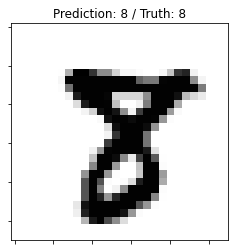

In [17]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [18]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical", "diagonal", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

def get_geo_dataset(name, filepath):
  path = tf.keras.utils.get_file(name, filepath)
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [19]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
       
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.3),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

18841600/18841002 [==============================] - 1s 0us/step
(28, 28)
1
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


30/30 [==============================] - 2s 39ms/step - loss: 1.7641 - accuracy: 0.1693 - val_loss: 1.6941 - val_accuracy: 0.1429
Epoch 2/15
30/30 [==============================] - 1s 26ms/step - loss: 1.5838 - accuracy: 0.3351 - val_loss: 1.0622 - val_accuracy: 0.7500
Epoch 3/15
30/30 [==============================] - 1s 26ms/step - loss: 0.9210 - accuracy: 0.7311 - val_loss: 0.6487 - val_accuracy: 0.7738
Epoch 4/15
30/30 [==============================] - 1s 26ms/step - loss: 0.6287 - accuracy: 0.8123 - val_loss: 0.4956 - val_accuracy: 0.7833
Epoch 5/15
30/30 [==============================] - 1s 26ms/step - loss: 0.5212 - accuracy: 0.8302 - val_loss: 0.3851 - val_accuracy: 0.9310
Epoch 6/15
30/30 [==============================] - 1s 27ms/step - loss: 0.3919 - accuracy: 0.9163 - val_loss: 0.3257 - val_accuracy: 0.9238
Epoch 7/15
30/30 [==============================] - 1s 26ms/step - loss: 0.3464 - accuracy: 0.9095 - val_loss: 0.2555 - val_accuracy: 0.9405
Epoch 8/15
30/30 [======

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


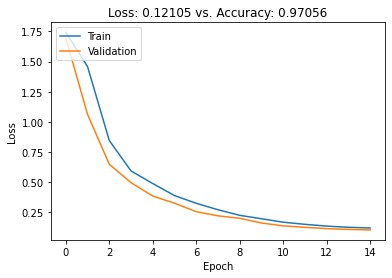

In [20]:
dataset = geo_dataset_simple
geo_train, geo_test = get_geo_dataset(dataset[0], dataset[1])
geo_train, geo_test = format_dataset(len(dataset[2]), geo_train, geo_test)
model_geo = create_geo_model("geocam", (28, 28, 1), len(dataset[2]))
# model_geo, history_geo = load_model("geo")

start_time = time.clock()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_geo, history_geo, "geo")

model_geo.summary()
score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)

plot_model_score(score_geo, history_geo.history)

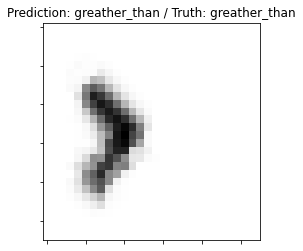

In [36]:
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, truth, prediction, dataset[2])

In [87]:
# CAM for GEO NN (Knowledge Domain Network)
cgeo_model = copy_model(model_geo)
geo_layers = get_cam_layers(cgeo_model)
geo_conv_layers = geo_layers[0]
geo_dense_layers = geo_layers[1]

model_geo_2 = keras.Sequential()
model_geo_2.stateful = True
for layer in geo_dense_layers:
  model_geo_2.add(layer)
model_geo_2.trainable = False

# Transfer-learning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1/5
422/422 [==============================] - 12s 28ms/step - loss: 4.2712 - accuracy: 0.5513 - val_loss: 0.1097 - val_accuracy: 0.9672
Epoch 2/5
422/422 [==============================] - 12s 27ms/step - loss: 0.1895 - accuracy: 0.9419 - val_loss: 0.0740 - val_accuracy: 0.9778
Epoch 3/5
422/422 [==============================] - 11s 27ms/step - loss: 0.1289 - accuracy: 0.9594 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 4/5
422/422 [==============================] - 11s 27ms/step - loss: 0.1051 - accuracy: 0.9676 - val_loss: 0.0529 - val_accuracy: 0.9848
Epoch 5/5
422/422 [==============================] - 11s 27ms/step - loss: 0.0983 - accuracy: 0.9690 - val_loss: 0.0493 - val_accuracy: 0.9838
Training took: 37.87 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 26, 26, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 13, 13, 128)     

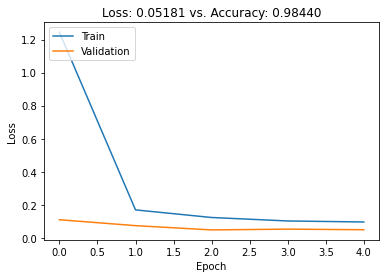

In [131]:
geo_layers = get_cam_layers(copy_model(model_geo, False))
mnist_layers = get_cam_layers(copy_model(model_mnist, True))

model_gcm = keras.Sequential()

for layer in geo_layers[0]:
  layer.trainable = False
  model_gcm.add(layer)

model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model_gcm.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model_gcm.add(layers.Dropout(0.3))
model_gcm.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model_gcm.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model_gcm.add(layers.Dropout(0.3))
model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model_gcm.add(layers.GlobalAveragePooling2D())
model_gcm.add(layers.Dense(mnist_num_classes, activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.002)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

start_time = time.clock()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=5, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))

score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
model_gcm.summary()
plot_model_score(score_gcm, history_geocam.history)

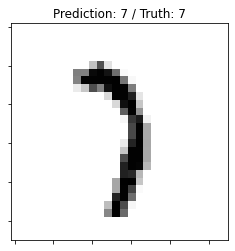

In [97]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# CAMs

In [24]:
def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  heatmap_model = Model([model.inputs], [cam_layers[0][con_layer_idx].get_output_at(0), model.output])

  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = heatmap_model(np.expand_dims(image, 0))
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, prediction_idx, (conv_first_grad, conv_second_grad, conv_third_grad)

In [25]:
def cam_1(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[1][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

# Experiments

conv output hash: 698FA4EA2370553F83AA1ED8C32FE540C751362BDF9C17A7838C95E7FFF656ED


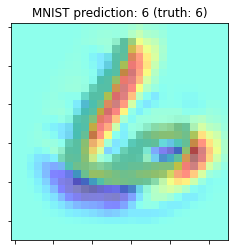

In [26]:
# debugging cams and values
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")

title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, (28, 28, 1), True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

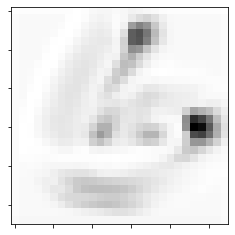

1st : ellipse (100.00%)
2nd : greather_than (0.22%)
3rd : diagonal (0.00%)


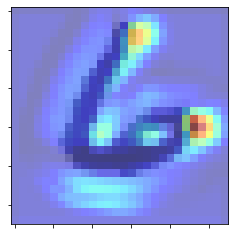

In [27]:
# prediction based on cam heatmap (SHOULD NOT WORK)

test_image, test_label = get_sample(mnist_test, 6187)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
heatmap = get_heatmap(gcm_mnist_cam, (28, 28)).reshape(28, 28, 1) * 255
prediction = predict(model_geo, heatmap)

show_image(heatmap)

labels = dataset[2]
sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

plt.figure(facecolor='white')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(test_image.reshape(28, 28), alpha=0.5, cmap='Greys')
plt.imshow(heatmap.reshape(28, 28), cmap='jet', alpha=0.5)
plt.show()  

1st : horizontal (100.00%)
2nd : ellipse (80.38%)
3rd : greather_than (50.35%)


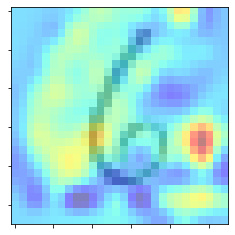

In [128]:
# prediction based on conv output
test_image, test_label = get_sample(mnist_test)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm, -4)
# print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")
assert test_label == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, test_label)

# Prediction
labels = dataset[2]
gcg_predictions = model_geo_2.predict(gcm_conv_output)
sorted_indexes = np.flip(np.argsort(gcg_predictions[0]))
percentages = gcg_predictions[0] / gcg_predictions[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Debug (CAM projection)
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, sorted_indexes[0])
show_heatmap(test_image, gcg_mnist_cam, (28, 28, 1), True)

# Metrics

In [138]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm 

digit_decomposition_categories = ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"]
digits_descriptions = [
  ["ellipse"], #0
  ["vertical", "diagonal"], #1
  ["horizontal", "diagonal"], #2
  ["lower_than", "horizontal"], #3
  ["vertical", "horizontal"], #4
  ["greather_than", "vertical", "horizontal"], #5
  ["diagonal", "ellipse"], #6
  ["diagonal", "horizontal"], #7
  ["ellipse"], #8
  ["ellipse", "diagonal"], #9
]

validation_amount = 100
validation_idxs = np.random.choice(validation_amount, len(mnist_test[0]))

y_true, y_pred = [], []
precision, recall = dict(), dict()
with tqdm(total=validation_amount, position=0, leave=True) as pbar:
  for i in range(validation_amount):
    validation_idx = validation_idxs[i]
    
    # true
    true_mnist_label = np.argmax(mnist_test[1][validation_idx])
    true_digit_decomposition_label = digits_descriptions[true_mnist_label][0]
    true_digit_decomposition_idx = digit_decomposition_categories.index(true_digit_decomposition_label)
    y_true.append(true_digit_decomposition_idx)

    # prediction
    test_mnist_image = mnist_test[0][validation_idx]
    gcm_mnist_cam, gcm_conv_output, _, _ = grad_cam_pp(test_mnist_image, model_gcm, -1)
    
    # cam map based prediction
    # image = get_heatmap(gcm_mnist_cam, (28, 28)).reshape(28, 28, 1) * 255
    # prediction = predict(model_geo, image)

    # conv output based prediction
    prediction = model_geo_2.predict(gcm_conv_output)

    score_digit_decomposition_idx = digit_decomposition_categories.index(dataset[2][np.argmax(prediction)])
    y_pred.append(score_digit_decomposition_idx)

    pbar.update()

y_true, y_pred = np.array(y_true), np.array(y_pred)

# metrics
print("\n\nMETRICS:")
print(f"- Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"- Precision: {precision_score(y_true, y_pred, average='weighted'):.2f}")
print(f"- Recall: {recall_score(y_true, y_pred, average='weighted'):.2f}")
print(f"- F1 score: {f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0):.2f}")

100%|██████████| 100/100 [00:06<00:00, 16.47it/s]



METRICS:
- Accuracy: 0.26
- Precision: 0.07
- Recall: 0.26
- F1 score: 0.20



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
